In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')

In [2]:
def make_toy_batch(batchsize=2):
    img = torch.zeros(batchsize, 1, 256, 256)
    mask = torch.zeros_like(img)
    for b in range(batchsize):
        x = torch.randint(32, 255-32, [])
        y = torch.randint(32, 255-32, [])

        mask[b,:,y-16:y+16,x-16:x+16] = 1
        img[b,:,y-16:y+16,x-16:x+16] = torch.rand(1,1,32,32) > 0.8
    
    return img, mask

In [3]:
CELLMASK = torch.Tensor([1,2,4,8]).to(torch.short)
GRID = torch.stack(torch.meshgrid(torch.arange(-.5, 16.5), torch.arange(-.5, 16.5)), dim=-1)
print(GRID.shape)

SW, SE, NE, NW = range(4)
SEGMENTS = [[] for _ in range(16)]
SEGMENTS[0b0000] = []
SEGMENTS[0b0001] = [[[NW, SW], [SE, SW]]]
SEGMENTS[0b0010] = [[[SW, SE], [NE, SE]]]
SEGMENTS[0b0011] = [[[NW, SW], [NE, SE]]]
SEGMENTS[0b0100] = [[[SE, NE], [NW, NE]]]
SEGMENTS[0b0101] = [[[NW, SW], [SE, SW]], [[SE, NE], [NW, NE]]]
SEGMENTS[0b0110] = [[[SW, SE], [NW, NE]]]
SEGMENTS[0b0111] = [[[NW, SW], [NW, NE]]]
SEGMENTS[0b1000] = [[[NE, NW], [SW, NW]]]
SEGMENTS[0b1001] = [[[NE, NW], [SE, SW]]]
SEGMENTS[0b1010] = [[[SW, SE], [NE, SE]], [[NE, NW], [SW, NW]]]
SEGMENTS[0b1011] = [[[NE, NW], [NE, SE]]]
SEGMENTS[0b1100] = [[[SE, NE], [SW, NW]]]
SEGMENTS[0b1101] = [[[SE, NE], [SE, SW]]]
SEGMENTS[0b1110] = [[[SW, SE], [SW, NW]]]
SEGMENTS[0b1111] = []

def marching_squares(coarse):
    coarse = F.pad(coarse, [1, 1, 1, 1], mode='replicate')
    coarse_class = coarse > 0
    nw = coarse[:,:,:-1,:-1]
    ne = coarse[:,:,:-1,1:]
    sw = coarse[:,:,1:,:-1]
    se = coarse[:,:,1:,1:]
    values = torch.stack([sw, se, ne, nw], dim=-1)
    
    cells = (values > 0).to(torch.short)
    cellidx = torch.tensordot(cells, CELLMASK, dims=([-1], [0]))
    
    batch_idx = []
    edges = []
    for b in range(cells.shape[0]):
        for y in range(cells.shape[2]):
            for x in range(cells.shape[3]):
                idx = cellidx[b, 0, y, x]
                segments = SEGMENTS[idx]
                if len(segments) == 0:
                    continue
                vals = values[b, 0, y, x]
                points = torch.tensor([[1, 0], [1, 1], [0, 1], [0, 0]]) + GRID[y, x]
                for (l1, u1), (l2, u2) in segments:
                    start = (vals[u1] * points[u1] - vals[l1] * points[l1]) / (vals[u1] - vals[l1])
                    stop  = (vals[u2] * points[u2] - vals[l2] * points[l2]) / (vals[u2] - vals[l2])
                    batch_idx.append(torch.Tensor([b]).to(torch.short))
                    edge = torch.cat([start, stop], dim=0)
                    edges.append(edge)
    return torch.stack(batch_idx, dim=0), torch.stack(edges, dim=0)

class SnakeNet(nn.Module):
    def __init__(self, input_channels, output_channels, base_channels=16):
        super().__init__()
        bc = base_channels

        # Backbone
        self.backbone = nn.Sequential(
            nn.Conv2d(input_channels, base_channels, 2, stride=2),
            nn.Conv2d(1 * bc, 2 * bc, 2, stride=2), nn.Tanh(),
            nn.Conv2d(2 * bc, 4 * bc, 2, stride=2), nn.Tanh(),
            nn.Conv2d(4 * bc, 8 * bc, 2, stride=2), nn.Tanh(),
        )
        
        self.make_coarse = nn.Conv2d(8 * bc, 1, 1)

    def forward(self, x):
        features = self.backbone(x)
        coarse = self.make_coarse(features)

        # Do Marching squares
        x = features

        return x, coarse

torch.Size([17, 17, 2])


In [4]:
net = SnakeNet(1, 1)
# opt = torch.optim.Adam(net.parameters(), 1e-3)jk
opt = torch.optim.SGD(net.parameters(), 1e-2, momentum=0.95, nesterov=True)

for i in range(500):
    img, mask = make_toy_batch()
    N, C, H, W = img.shape
    coarse_target = mask.view(N, C, H // 16, 16, W // 16, 16)
    coarse_target = coarse_target.transpose(3, 4)
    coarse_target = coarse_target.reshape(N, C, H // 16, W // 16, -1)
    coarse_target = coarse_target.max(dim=-1)[0]
    x, coarse = net(img)

    coarse_loss = F.binary_cross_entropy_with_logits(coarse, coarse_target)
    opt.zero_grad()
    coarse_loss.backward()
    opt.step()
    if (i+1) % 100 == 0:
        print(coarse_loss.item())

print(img.shape, '->', coarse.shape)

0.1513497531414032
0.14441753923892975
0.07437025010585785
0.04840894043445587
0.02352580986917019
torch.Size([2, 1, 256, 256]) -> torch.Size([2, 1, 16, 16])


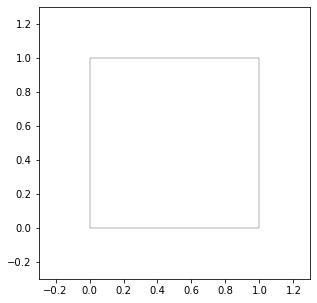

In [5]:
i = 0b1111

points = np.array([[0, 0], [1, 0], [1, 1], [0, 1]])

fig, ax = plt.subplots(figsize=(5, 5))
def showpoint(pt, *args, **kwargs):
    x, y = pt
    ax.scatter([x], [y], *args, **kwargs)
    
for (lower1, upper1), (lower2, upper2) in SEGMENTS[i]:
    showpoint(points[lower1], c='w', edgecolors='k')
    showpoint(points[lower2], c='w', edgecolors='k')
    showpoint(points[upper1], c='k', edgecolors='k')
    showpoint(points[upper2], c='k', edgecolors='k')
    start = 0.5 * (points[lower1] + points[upper1])
    stop  = 0.5 * (points[lower2] + points[upper2])
    d = stop - start
    plt.quiver(start[[0]], start[[1]], d[[0]], d[[1]], scale=1, scale_units='xy')

ax.vlines([0, 1], 0, 1, linewidth=0.3)
ax.hlines([0, 1], 0, 1, linewidth=0.3)
ax.set_xlim([-.3, 1.3])
ax.set_ylim([-.3, 1.3])
ax.set_aspect('equal')

(256.0, 0.0)

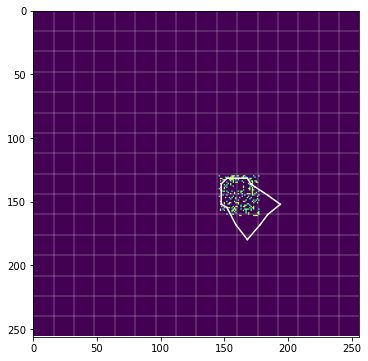

In [6]:
# sy, sx = 16 * start.detach().numpy()
# ty, tx = 16 * stop.detach().numpy()
# dy, dx = ty - sy, tx - sx
# plt.quiver([sx], [sy], [dy], [dx], scale=1, scale_units='xy')
# plt.subplot(1, 2, 1)
plt.imshow(img[0,0])
batch_idx, edges = marching_squares(coarse)
for b, (sy, sx, ty, tx) in zip(batch_idx, 16 * edges):
    if b == 0:
        plt.plot([sx, tx], [sy, ty], c='w')
        
plt.vlines(np.arange(0, 256, 16), 0, 256, 'w', linewidth=0.3)
plt.hlines(np.arange(0, 256, 16), 0, 256, 'w', linewidth=0.3)
plt.xlim([0, 256])
plt.ylim([256, 0])

In [7]:
plt.imshow(make_toy_example()[0,0])

NameError: name 'make_toy_example' is not defined

In [8]:
torch.zeros(0, 2)

tensor([], size=(0, 2))